The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.3


# Linear Regression
:label:`sec_linear_regression`

*Regression* problems pop up whenever we want to predict a numerical value.
Common examples include predicting prices (of homes, stocks, etc.),
predicting the length of stay (for patients in the hospital),
forecasting demand (for retail sales), among numerous others.
Not every prediction problem is one of classical regression.
Later on, we will introduce classification problems,
where the goal is to predict membership among a set of categories.

As a running example, suppose that we wish
to estimate the prices of houses (in dollars)
based on their area (in square feet) and age (in years).
To develop a model for predicting house prices,
we need to get our hands on data,
including the sales price, area, and age for each home.
In the terminology of machine learning,
the dataset is called a *training dataset* or *training set*,
and each row (containing the data corresponding to one sale)
is called an *example* (or *data point*, *instance*, *sample*).
The thing we are trying to predict (price)
is called a *label* (or *target*).
The variables (age and area)
upon which the predictions are based
are called *features* (or *covariates*).


In [ ]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

## Basics

*Linear regression* is both the simplest
and most popular among the standard tools
for tackling regression problems.
Dating back to the dawn of the 19th century :cite:`Legendre.1805,Gauss.1809`,
linear regression flows from a few simple assumptions.
First, we assume that the relationship
between features $\mathbf{x}$ and target $y$
is approximately linear,
i.e., that the conditional mean $E[Y \mid X=\mathbf{x}]$
can be expressed as a weighted sum
of the features $\mathbf{x}$.
This setup allows that the target value
may still deviate from its expected value
on account of observation noise.
Next, we can impose the assumption that any such noise
is well behaved, following a Gaussian distribution.
Typically, we will use $n$ to denote
the number of examples in our dataset.
We use superscripts to enumerate samples and targets,
and subscripts to index coordinates.
More concretely,
$\mathbf{x}^{(i)}$ denotes the $i^{\textrm{th}}$ sample
and $x_j^{(i)}$ denotes its $j^{\textrm{th}}$ coordinate.

### Model
:label:`subsec_linear_model`

At the heart of every solution is a model
that describes how features can be transformed
into an estimate of the target.
The assumption of linearity means that
the expected value of the target (price) can be expressed
as a weighted sum of the features (area and age):

$$\textrm{price} = w_{\textrm{area}} \cdot \textrm{area} + w_{\textrm{age}} \cdot \textrm{age} + b.$$
:eqlabel:`eq_price-area`

Here $w_{\textrm{area}}$ and $w_{\textrm{age}}$
are called *weights*, and $b$ is called a *bias*
(or *offset* or *intercept*).
The weights determine the influence of each feature on our prediction.
The bias determines the value of the estimate when all features are zero.
Even though we will never see any newly-built homes with precisely zero area,
we still need the bias because it allows us
to express all linear functions of our features
(rather than restricting us to lines that pass through the origin).
Strictly speaking, :eqref:`eq_price-area` is an *affine transformation* of input features, which is characterized by a *linear transformation* of features via a weighted sum, combined with a *translation* via the added bias.
Given a dataset, our goal is to choose
the weights $\mathbf{w}$ and the bias $b$
that, on average, make our model's predictions
fit the true prices observed in the data as closely as possible.


In disciplines where it is common to focus
on datasets with just a few features,
explicitly expressing models long-form,
as in :eqref:`eq_price-area`, is common.
In machine learning, we usually work
with high-dimensional datasets,
where it is more convenient to employ
compact linear algebra notation.
When our inputs consist of $d$ features,
we can assign each an index (between $1$ and $d$)
and express our prediction $\hat{y}$
(in general the "hat" symbol denotes an estimate) as

$$\hat{y} = w_1  x_1 + \cdots + w_d  x_d + b.$$

Collecting all features into a vector $\mathbf{x} \in \mathbb{R}^d$
and all weights into a vector $\mathbf{w} \in \mathbb{R}^d$,
we can express our model compactly via the dot product
between $\mathbf{w}$ and $\mathbf{x}$:

$$\hat{y} = \mathbf{w}^\top \mathbf{x} + b.$$
:eqlabel:`eq_linreg-y`

In :eqref:`eq_linreg-y`, the vector $\mathbf{x}$
corresponds to the features of a single example.
We will often find it convenient
to refer to features of our entire dataset of $n$ examples
via the *design matrix* $\mathbf{X} \in \mathbb{R}^{n \times d}$.
Here, $\mathbf{X}$ contains one row for every example
and one column for every feature.
For a collection of features $\mathbf{X}$,
the predictions $\hat{\mathbf{y}} \in \mathbb{R}^n$
can be expressed via the matrix--vector product:

$${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b,$$
:eqlabel:`eq_linreg-y-vec`

where broadcasting (:numref:`subsec_broadcasting`) is applied during the summation.
Given features of a training dataset $\mathbf{X}$
and corresponding (known) labels $\mathbf{y}$,
the goal of linear regression is to find
the weight vector $\mathbf{w}$ and the bias term $b$
such that, given features of a new data example
sampled from the same distribution as $\mathbf{X}$,
the new example's label will (in expectation)
be predicted with the smallest error.

Even if we believe that the best model for
predicting $y$ given $\mathbf{x}$ is linear,
we would not expect to find a real-world dataset of $n$ examples where
$y^{(i)}$ exactly equals $\mathbf{w}^\top \mathbf{x}^{(i)}+b$
for all $1 \leq i \leq n$.
For example, whatever instruments we use to observe
the features $\mathbf{X}$ and labels $\mathbf{y}$, there might be a small amount of measurement error.
Thus, even when we are confident
that the underlying relationship is linear,
we will incorporate a noise term to account for such errors.

Before we can go about searching for the best *parameters*
(or *model parameters*) $\mathbf{w}$ and $b$,
we will need two more things:
(i) a measure of the quality of some given model;
and (ii) a procedure for updating the model to improve its quality.

### Loss Function
:label:`subsec_linear-regression-loss-function`

Naturally, fitting our model to the data requires
that we agree on some measure of *fitness*
(or, equivalently, of *unfitness*).
*Loss functions* quantify the distance
between the *real* and *predicted* values of the target.
The loss will usually be a nonnegative number
where smaller values are better
and perfect predictions incur a loss of 0.
For regression problems, the most common loss function is the squared error.
When our prediction for an example $i$ is $\hat{y}^{(i)}$
and the corresponding true label is $y^{(i)}$,
the *squared error* is given by:

$$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2.$$
:eqlabel:`eq_mse`

The constant $\frac{1}{2}$ makes no real difference
but proves to be notationally convenient,
since it cancels out when we take the derivative of the loss.
Because the training dataset is given to us,
and thus is out of our control,
the empirical error is only a function of the model parameters.
In :numref:`fig_fit_linreg`, we visualize the fit of a linear regression model
in a problem with one-dimensional inputs.

![Fitting a linear regression model to one-dimensional data.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/fit-linreg.svg?raw=1)
:label:`fig_fit_linreg`

Note that large differences between
estimates $\hat{y}^{(i)}$ and targets $y^{(i)}$
lead to even larger contributions to the loss,
due to its quadratic form
(this quadraticity can be a double-edge sword; while it encourages the model to avoid large errors
it can also lead to excessive sensitivity to anomalous data).
To measure the quality of a model on the entire dataset of $n$ examples,
we simply average (or equivalently, sum)
the losses on the training set:

$$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

When training the model, we seek parameters ($\mathbf{w}^*, b^*$)
that minimize the total loss across all training examples:

$$\mathbf{w}^*, b^* = \operatorname*{argmin}_{\mathbf{w}, b}\  L(\mathbf{w}, b).$$

### Analytic Solution

Unlike most of the models that we will cover,
linear regression presents us with
a surprisingly easy optimization problem.
In particular, we can find the optimal parameters
(as assessed on the training data)
analytically by applying a simple formula as follows.
First, we can subsume the bias $b$ into the parameter $\mathbf{w}$
by appending a column to the design matrix consisting of all 1s.
Then our prediction problem is to minimize $\|\mathbf{y} - \mathbf{X}\mathbf{w}\|^2$.
As long as the design matrix $\mathbf{X}$ has full rank
(no feature is linearly dependent on the others),
then there will be just one critical point on the loss surface
and it corresponds to the minimum of the loss over the entire domain.
Taking the derivative of the loss with respect to $\mathbf{w}$
and setting it equal to zero yields:

$$\begin{aligned}
    \partial_{\mathbf{w}} \|\mathbf{y} - \mathbf{X}\mathbf{w}\|^2 =
    2 \mathbf{X}^\top (\mathbf{X} \mathbf{w} - \mathbf{y}) = 0
    \textrm{ and hence }
    \mathbf{X}^\top \mathbf{y} = \mathbf{X}^\top \mathbf{X} \mathbf{w}.
\end{aligned}$$

Solving for $\mathbf{w}$ provides us with the optimal solution
for the optimization problem.
Note that this solution

$$\mathbf{w}^* = (\mathbf X^\top \mathbf X)^{-1}\mathbf X^\top \mathbf{y}$$

will only be unique
when the matrix $\mathbf X^\top \mathbf X$ is invertible,
i.e., when the columns of the design matrix
are linearly independent :cite:`Golub.Van-Loan.1996`.



While simple problems like linear regression
may admit analytic solutions,
you should not get used to such good fortune.
Although analytic solutions allow for nice mathematical analysis,
the requirement of an analytic solution is so restrictive
that it would exclude almost all exciting aspects of deep learning.

### Minibatch Stochastic Gradient Descent

Fortunately, even in cases where we cannot solve the models analytically,
we can still often train models effectively in practice.
Moreover, for many tasks, those hard-to-optimize models
turn out to be so much better that figuring out how to train them
ends up being well worth the trouble.

The key technique for optimizing nearly every deep learning model,
and which we will call upon throughout this book,
consists of iteratively reducing the error
by updating the parameters in the direction
that incrementally lowers the loss function.
This algorithm is called *gradient descent*.

The most naive application of gradient descent
consists of taking the derivative of the loss function,
which is an average of the losses computed
on every single example in the dataset.
In practice, this can be extremely slow:
we must pass over the entire dataset before making a single update,
even if the update steps might be very powerful :cite:`Liu.Nocedal.1989`.
Even worse, if there is a lot of redundancy in the training data,
the benefit of a full update is limited.

The other extreme is to consider only a single example at a time and to take
update steps based on one observation at a time.
The resulting algorithm, *stochastic gradient descent* (SGD)
can be an effective strategy :cite:`Bottou.2010`, even for large datasets.
Unfortunately, SGD has drawbacks, both computational and statistical.
One problem arises from the fact that processors are a lot faster
multiplying and adding numbers than they are
at moving data from main memory to processor cache.
It is up to an order of magnitude more efficient to
perform a matrix--vector multiplication
than a corresponding number of vector--vector operations.
This means that it can take a lot longer to process
one sample at a time compared to a full batch.
A second problem is that some of the layers,
such as batch normalization (to be described in :numref:`sec_batch_norm`),
only work well when we have access
to more than one observation at a time.

The solution to both problems is to pick an intermediate strategy:
rather than taking a full batch or only a single sample at a time,
we take a *minibatch* of observations :cite:`Li.Zhang.Chen.ea.2014`.
The specific choice of the size of the said minibatch depends on many factors,
such as the amount of memory, the number of accelerators,
the choice of layers, and the total dataset size.
Despite all that, a number between 32 and 256,
preferably a multiple of a large power of $2$, is a good start.
This leads us to *minibatch stochastic gradient descent*.

In its most basic form, in each iteration $t$,
we first randomly sample a minibatch $\mathcal{B}_t$
consisting of a fixed number $|\mathcal{B}|$ of training examples.
We then compute the derivative (gradient) of the average loss
on the minibatch with respect to the model parameters.
Finally, we multiply the gradient
by a predetermined small positive value $\eta$,
called the *learning rate*,
and subtract the resulting term from the current parameter values.
We can express the update as follows:

$$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b).$$

In summary, minibatch SGD proceeds as follows:
(i) initialize the values of the model parameters, typically at random;
(ii) iteratively sample random minibatches from the data,
updating the parameters in the direction of the negative gradient.
For quadratic losses and affine transformations,
this has a closed-form expansion:

$$\begin{aligned} \mathbf{w} & \leftarrow \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_{\mathbf{w}} l^{(i)}(\mathbf{w}, b) && = \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)\\ b &\leftarrow b -  \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_b l^{(i)}(\mathbf{w}, b) &&  = b - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right). \end{aligned}$$
:eqlabel:`eq_linreg_batch_update`

Since we pick a minibatch $\mathcal{B}$
we need to normalize by its size $|\mathcal{B}|$.
Frequently minibatch size and learning rate are user-defined.
Such tunable parameters that are not updated
in the training loop are called *hyperparameters*.
They can be tuned automatically by a number of techniques, such as Bayesian optimization
:cite:`Frazier.2018`. In the end, the quality of the solution is
typically assessed on a separate *validation dataset* (or *validation set*).

After training for some predetermined number of iterations
(or until some other stopping criterion is met),
we record the estimated model parameters,
denoted $\hat{\mathbf{w}}, \hat{b}$.
Note that even if our function is truly linear and noiseless,
these parameters will not be the exact minimizers of the loss, nor even deterministic.
Although the algorithm converges slowly towards the minimizers
it typically will not find them exactly in a finite number of steps.
Moreover, the minibatches $\mathcal{B}$
used for updating the parameters are chosen at random.
This breaks determinism.

Linear regression happens to be a learning problem
with a global minimum
(whenever $\mathbf{X}$ is full rank, or equivalently,
whenever $\mathbf{X}^\top \mathbf{X}$ is invertible).
However, the loss surfaces for deep networks contain many saddle points and minima.
Fortunately, we typically do not care about finding
an exact set of parameters but merely any set of parameters
that leads to accurate predictions (and thus low loss).
In practice, deep learning practitioners
seldom struggle to find parameters
that minimize the loss *on training sets*
:cite:`Izmailov.Podoprikhin.Garipov.ea.2018,Frankle.Carbin.2018`.
The more formidable task is to find parameters
that lead to accurate predictions on previously unseen data,
a challenge called *generalization*.
We return to these topics throughout the book.

### Predictions

Given the model $\hat{\mathbf{w}}^\top \mathbf{x} + \hat{b}$,
we can now make *predictions* for a new example,
e.g., predicting the sales price of a previously unseen house
given its area $x_1$ and age $x_2$.
Deep learning practitioners have taken to calling the prediction phase *inference*
but this is a bit of a misnomer---*inference* refers broadly
to any conclusion reached on the basis of evidence,
including both the values of the parameters
and the likely label for an unseen instance.
If anything, in the statistics literature
*inference* more often denotes parameter inference
and this overloading of terminology creates unnecessary confusion
when deep learning practitioners talk to statisticians.
In the following we will stick to *prediction* whenever possible.



## Vectorization for Speed

When training our models, we typically want to process
whole minibatches of examples simultaneously.
Doing this efficiently requires that (**we**) (~~should~~)
(**vectorize the calculations and leverage
fast linear algebra libraries
rather than writing costly for-loops in Python.**)

To see why this matters so much,
let's (**consider two methods for adding vectors.**)
To start, we instantiate two 10,000-dimensional vectors
containing all 1s.
In the first method, we loop over the vectors with a Python for-loop.
In the second, we rely on a single call to `+`.


In [ ]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

Now we can benchmark the workloads.
First, [**we add them, one coordinate at a time,
using a for-loop.**]


In [ ]:
c = torch.zeros(n)
t = time.time()
for i in range(n):
    c[i] = a[i] + b[i]
f'{time.time() - t:.5f} sec'

'0.17802 sec'

(**Alternatively, we rely on the reloaded `+` operator to compute the elementwise sum.**)


In [ ]:
t = time.time()
d = a + b
f'{time.time() - t:.5f} sec'

'0.00036 sec'

The second method is dramatically faster than the first.
Vectorizing code often yields order-of-magnitude speedups.
Moreover, we push more of the mathematics to the library
so we do not have to write as many calculations ourselves,
reducing the potential for errors and increasing portability of the code.


## The Normal Distribution and Squared Loss
:label:`subsec_normal_distribution_and_squared_loss`

So far we have given a fairly functional motivation
of the squared loss objective:
the optimal parameters return the conditional expectation $E[Y\mid X]$
whenever the underlying pattern is truly linear,
and the loss assigns large penalties for outliers.
We can also provide a more formal motivation
for the squared loss objective
by making probabilistic assumptions
about the distribution of noise.

Linear regression was invented at the turn of the 19th century.
While it has long been debated whether Gauss or Legendre
first thought up the idea,
it was Gauss who also discovered the normal distribution
(also called the *Gaussian*).
It turns out that the normal distribution
and linear regression with squared loss
share a deeper connection than common parentage.

To begin, recall that a normal distribution
with mean $\mu$ and variance $\sigma^2$ (standard deviation $\sigma$)
is given as

$$p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (x - \mu)^2\right).$$

Below [**we define a function to compute the normal distribution**].


In [ ]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 * (x - mu)**2 / sigma**2)

We can now (**visualize the normal distributions**).


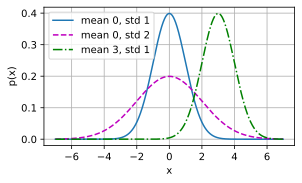

In [ ]:
# Use NumPy again for visualization
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

Note that changing the mean corresponds
to a shift along the $x$-axis,
and increasing the variance
spreads the distribution out,
lowering its peak.

One way to motivate linear regression with squared loss
is to assume that observations arise from noisy measurements,
where the noise $\epsilon$ follows the normal distribution
$\mathcal{N}(0, \sigma^2)$:

$$y = \mathbf{w}^\top \mathbf{x} + b + \epsilon \textrm{ where } \epsilon \sim \mathcal{N}(0, \sigma^2).$$

Thus, we can now write out the *likelihood*
of seeing a particular $y$ for a given $\mathbf{x}$ via

$$P(y \mid \mathbf{x}) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (y - \mathbf{w}^\top \mathbf{x} - b)^2\right).$$

As such, the likelihood factorizes.
According to *the principle of maximum likelihood*,
the best values of parameters $\mathbf{w}$ and $b$ are those
that maximize the *likelihood* of the entire dataset:

$$P(\mathbf y \mid \mathbf X) = \prod_{i=1}^{n} p(y^{(i)} \mid \mathbf{x}^{(i)}).$$

The equality follows since all pairs $(\mathbf{x}^{(i)}, y^{(i)})$
were drawn independently of each other.
Estimators chosen according to the principle of maximum likelihood
are called *maximum likelihood estimators*.
While, maximizing the product of many exponential functions,
might look difficult,
we can simplify things significantly, without changing the objective,
by maximizing the logarithm of the likelihood instead.
For historical reasons, optimizations are more often expressed
as minimization rather than maximization.
So, without changing anything,
we can *minimize* the *negative log-likelihood*,
which we can express as follows:

$$-\log P(\mathbf y \mid \mathbf X) = \sum_{i=1}^n \frac{1}{2} \log(2 \pi \sigma^2) + \frac{1}{2 \sigma^2} \left(y^{(i)} - \mathbf{w}^\top \mathbf{x}^{(i)} - b\right)^2.$$

If we assume that $\sigma$ is fixed,
we can ignore the first term,
because it does not depend on $\mathbf{w}$ or $b$.
The second term is identical
to the squared error loss introduced earlier,
except for the multiplicative constant $\frac{1}{\sigma^2}$.
Fortunately, the solution does not depend on $\sigma$ either.
It follows that minimizing the mean squared error
is equivalent to the maximum likelihood estimation
of a linear model under the assumption of additive Gaussian noise.


## Linear Regression as a Neural Network

While linear models are not sufficiently rich
to express the many complicated networks
that we will introduce in this book,
(artificial) neural networks are rich enough
to subsume linear models as networks
in which every feature is represented by an input neuron,
all of which are connected directly to the output.

:numref:`fig_single_neuron` depicts
linear regression as a neural network.
The diagram highlights the connectivity pattern,
such as how each input is connected to the output,
but not the specific values taken by the weights or biases.

![Linear regression is a single-layer neural network.](http://d2l.ai/_images/singleneuron.svg)
:label:`fig_single_neuron`

The inputs are $x_1, \ldots, x_d$.
We refer to $d$ as the *number of inputs*
or the *feature dimensionality* in the input layer.
The output of the network is $o_1$.
Because we are just trying to predict
a single numerical value,
we have only one output neuron.
Note that the input values are all *given*.
There is just a single *computed* neuron.
In summary, we can think of linear regression
as a single-layer fully connected neural network.
We will encounter networks
with far more layers
in later chapters.

### Biology

Because linear regression predates computational neuroscience,
it might seem anachronistic to describe
linear regression in terms of neural networks.
Nonetheless, they were a natural place to start
when the cyberneticists and neurophysiologists
Warren McCulloch and Walter Pitts began to develop
models of artificial neurons.
Consider the cartoonish picture
of a biological neuron in :numref:`fig_Neuron`,
consisting of *dendrites* (input terminals),
the *nucleus* (CPU), the *axon* (output wire),
and the *axon terminals* (output terminals),
enabling connections to other neurons via *synapses*.

![The real neuron (source: "Anatomy and Physiology" by the US National Cancer Institute's Surveillance, Epidemiology and End Results (SEER) Program).](http://d2l.ai/_images/neuron.svg)
:label:`fig_Neuron`

Information $x_i$ arriving from other neurons
(or environmental sensors) is received in the dendrites.
In particular, that information is weighted
by *synaptic weights* $w_i$,
determining the effect of the inputs,
e.g., activation or inhibition via the product $x_i w_i$.
The weighted inputs arriving from multiple sources
are aggregated in the nucleus
as a weighted sum $y = \sum_i x_i w_i + b$,
possibly subject to some nonlinear postprocessing via a function $\sigma(y)$.
This information is then sent via the axon to the axon terminals,
where it reaches its destination
(e.g., an actuator such as a muscle)
or it is fed into another neuron via its dendrites.

Certainly, the high-level idea that many such units
could be combined, provided they have the correct connectivity and learning algorithm,
to produce far more interesting and complex behavior
than any one neuron alone could express
arises from our study of real biological neural systems.
At the same time, most research in deep learning today
draws inspiration from a much wider source.
We invoke :citet:`Russell.Norvig.2016`
who pointed out that although airplanes might have been *inspired* by birds,
ornithology has not been the primary driver
of aeronautics innovation for some centuries.
Likewise, inspiration in deep learning these days
comes in equal or greater measure
from mathematics, linguistics, psychology,
statistics, computer science, and many other fields.

## Summary

In this section, we introduced
traditional linear regression,
where the parameters of a linear function
are chosen to minimize squared loss on the training set.
We also motivated this choice of objective
both via some practical considerations
and through an interpretation
of linear regression as maximimum likelihood estimation
under an assumption of linearity and Gaussian noise.
After discussing both computational considerations
and connections to statistics,
we showed how such linear models could be expressed
as simple neural networks where the inputs
are directly wired to the output(s).
While we will soon move past linear models altogether,
they are sufficient to introduce most of the components
that all of our models require:
parametric forms, differentiable objectives,
optimization via minibatch stochastic gradient descent,
and ultimately, evaluation on previously unseen data.



## Exercises

1. Assume that we have some data $x_1, \ldots, x_n \in \mathbb{R}$. Our goal is to find a constant $b$ such that $\sum_i (x_i - b)^2$ is minimized.
    1. Find an analytic solution for the optimal value of $b$.
    1. How does this problem and its solution relate to the normal distribution?
    1. What if we change the loss from $\sum_i (x_i - b)^2$ to $\sum_i |x_i-b|$? Can you find the optimal solution for $b$?
1. Prove that the affine functions that can be expressed by $\mathbf{x}^\top \mathbf{w} + b$ are equivalent to linear functions on $(\mathbf{x}, 1)$.
1. Assume that you want to find quadratic functions of $\mathbf{x}$, i.e., $f(\mathbf{x}) = b + \sum_i w_i x_i + \sum_{j \leq i} w_{ij} x_{i} x_{j}$. How would you formulate this in a deep network?
1. Recall that one of the conditions for the linear regression problem to be solvable was that the design matrix $\mathbf{X}^\top \mathbf{X}$ has full rank.
    1. What happens if this is not the case?
    1. How could you fix it? What happens if you add a small amount of coordinate-wise independent Gaussian noise to all entries of $\mathbf{X}$?
    1. What is the expected value of the design matrix $\mathbf{X}^\top \mathbf{X}$ in this case?
    1. What happens with stochastic gradient descent when $\mathbf{X}^\top \mathbf{X}$ does not have full rank?
1. Assume that the noise model governing the additive noise $\epsilon$ is the exponential distribution. That is, $p(\epsilon) = \frac{1}{2} \exp(-|\epsilon|)$.
    1. Write out the negative log-likelihood of the data under the model $-\log P(\mathbf y \mid \mathbf X)$.
    1. Can you find a closed form solution?
    1. Suggest a minibatch stochastic gradient descent algorithm to solve this problem. What could possibly go wrong (hint: what happens near the stationary point as we keep on updating the parameters)? Can you fix this?
1. Assume that we want to design a neural network with two layers by composing two linear layers. That is, the output of the first layer becomes the input of the second layer. Why would such a naive composition not work?
1. What happens if you want to use regression for realistic price estimation of houses or stock prices?
    1. Show that the additive Gaussian noise assumption is not appropriate. Hint: can we have negative prices? What about fluctuations?
    1. Why would regression to the logarithm of the price be much better, i.e., $y = \log \textrm{price}$?
    1. What do you need to worry about when dealing with pennystock, i.e., stock with very low prices? Hint: can you trade at all possible prices? Why is this a bigger problem for cheap stock? For more information review the celebrated Black--Scholes model for option pricing :cite:`Black.Scholes.1973`.
1. Suppose we want to use regression to estimate the *number* of apples sold in a grocery store.
    1. What are the problems with a Gaussian additive noise model? Hint: you are selling apples, not oil.
    1. The [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) captures distributions over counts. It is given by $p(k \mid \lambda) = \lambda^k e^{-\lambda}/k!$. Here $\lambda$ is the rate function and $k$ is the number of events you see. Prove that $\lambda$ is the expected value of counts $k$.
    1. Design a loss function associated with the Poisson distribution.
    1. Design a loss function for estimating $\log \lambda$ instead.


### Exercise 7

What happens if you want to use regression for realistic price estimation of houses or stock prices?

1.  Show that the additive Gaussian noise assumption is not appropriate. Hint: can we have negative prices? What about fluctuations?

The additive Gaussian noise assumption in linear regression is given by $y = \mathbf{w}^\top \mathbf{x} + b + \epsilon$, where $\epsilon \sim \mathcal{N}(0, \sigma^2)$. This assumes that the noise is centered around zero and can take any real value, positive or negative.

For realistic price estimation of houses or stock prices, this assumption is often **not appropriate** for several reasons:

*   **Non-negativity of Prices:** Prices (of houses or stocks) are inherently non-negative. An additive Gaussian noise model allows for negative noise values, which could lead to negative predicted prices, which is physically impossible and nonsensical in this context.
*   **Fluctuations are Often Multiplicative, Not Additive:** Price fluctuations are often proportional to the current price, rather than being a fixed additive amount. For example, a 1% fluctuation on a $100 stock is $1, while a 1% fluctuation on a $1000 stock is $10. An additive noise model assumes the magnitude of the noise is independent of the price level. This is not realistic for many financial or economic time series.
*   **Heteroscedasticity:** The variance of price fluctuations is often not constant across all price levels. For example, the price of a low-priced "penny stock" might fluctuate by a few cents, while the price of a high-priced stock might fluctuate by several dollars. An additive Gaussian noise model assumes constant variance ($\sigma^2$), which is often violated in real-world price data.

Due to these issues, especially the non-negativity constraint and the multiplicative nature of fluctuations, the simple additive Gaussian noise model is a poor fit for realistic price estimation and can lead to inaccurate and unreasonable predictions.

2.  Why would regression to the logarithm of the price be much better, i.e., $y = \log \textrm{price}$?

Regressing to the logarithm of the price, i.e., using $y = \log(\textrm{price})$ as the target variable instead of the price itself, can be much better for realistic price estimation for the following reasons:

*   **Ensuring Non-Negativity:** The logarithm function is only defined for positive values. By modeling $\log(\textrm{price})$, any predicted value for $y$ will correspond to a positive price when you exponentiate it ($\textrm{price} = e^y$). This naturally handles the non-negativity constraint of prices, which is a major issue with the simple additive Gaussian noise model on the raw price.
*   **Modeling Multiplicative Fluctuations as Additive Noise:** If we assume that price fluctuations are multiplicative (e.g., price changes by a percentage), taking the logarithm transforms these multiplicative changes into additive changes.
    If Price$_{t+1} = \textrm{Price}_t \times \textrm{Multiplier}$, then $\log(\textrm{Price}_{t+1}) = \log(\textrm{Price}_t) + \log(\textrm{Multiplier})$.
    If the logarithm of the multiplier is approximately normally distributed with constant variance, then the additive noise assumption becomes more appropriate for the log-price. This is often a more realistic assumption for financial time series.
*   **Handling Heteroscedasticity:** Taking the logarithm can also help to stabilize the variance of the noise across different price levels. In many cases, the variance of the *percentage* change in price is more constant than the variance of the absolute change in price. Since the logarithm transforms percentage changes into additive differences, it can lead to more homoscedastic residuals (constant variance noise) in the log-price space, which aligns better with the assumptions of linear regression.
*   **Improved Interpretation:** In some contexts, changes in log-price can be interpreted as percentage changes, which can be more intuitive for analyzing price movements.

By modeling the logarithm of the price, we are effectively fitting a linear model to the log-transformed data. This is equivalent to fitting an exponential model to the original price data with multiplicative noise. This often provides a more appropriate and robust model for non-negative values with multiplicative fluctuations, like prices.

3.  What do you need to worry about when dealing with pennystock, i.e., stock with very low prices? Hint: can you trade at all possible prices? Why is this a bigger problem for cheap stock? For more information review the celebrated Black--Scholes model for option pricing :cite:Black.Scholes.1973.

When dealing with pennystocks (stocks with very low prices, typically below $5), several issues arise that make realistic price estimation challenging, even when using techniques like regressing on the logarithm of the price:

*   **Discrete Price Movements (Tick Size):** Stock prices don't move in continuous increments. They move in discrete steps called "ticks". For most stocks, the tick size is $0.01 (one cent). For pennystocks, this discrete movement is a much larger *percentage* of the stock price.
    *   **Why this is a bigger problem for cheap stock:** If a stock is priced at $100, a $0.01 tick size is a 0.01% change. If a pennystock is priced at $0.10, a $0.01 tick size is a 10% change. This means that the price movements of pennystocks are inherently more lumpy and less like the continuous fluctuations assumed by many models (including those based on log-prices with continuous noise). The discrete nature of price changes becomes a dominant factor.
*   **Bid-Ask Spread:** The difference between the price at which you can buy a stock (ask price) and the price at which you can sell it (bid price) is called the bid-ask spread. For pennystocks, this spread is often a much larger percentage of the stock price than for higher-priced stocks. This makes it difficult to define a single "price" for the stock and introduces significant transaction costs that models need to account for.
*   **Low Liquidity and Manipulation:** Pennystocks often have low trading volume (low liquidity). This means that large buy or sell orders can have a significant impact on the price, making them more susceptible to manipulation. Models trained on historical data might not accurately predict prices influenced by such factors.
*   **Lack of Data Quality and Availability:** Data for pennystocks can sometimes be less reliable or harder to obtain than for larger, more established stocks.

While regressing on the logarithm of the price helps with the non-negativity and multiplicative noise assumptions, the discrete nature of price movements (the tick size) is a significant challenge for pennystocks. The assumption of continuous price paths, which underlies many financial models and the idea of continuous noise in log-price regression, breaks down for very low prices where the tick size is a substantial fraction of the price. This is a limitation that needs to be considered when applying continuous models to discrete, low-valued assets. The Black-Scholes model, for instance, assumes continuous trading and continuous price movements, which is a poor fit for the realities of pennystocks.

### Exercise 8

Suppose we want to use regression to estimate the *number* of apples sold in a grocery store.

1.  What are the problems with a Gaussian additive noise model? Hint: you are selling apples, not oil.

When estimating the number of apples sold in a grocery store, using a Gaussian additive noise model (as in standard linear regression) has several problems:

*   **Discrete, Non-Negative Counts:** The number of apples sold is a count; it must be a non-negative integer (0, 1, 2, ...). A Gaussian distribution is continuous and can take any real value, including negative and fractional values. An additive Gaussian noise model could lead to predictions of negative or fractional numbers of apples, which are not physically possible.
*   **Variance Related to the Mean:** For count data, the variance is often related to the mean. Specifically, for a Poisson distribution (which is often a good model for counts), the variance is equal to the mean. A Gaussian additive noise model assumes a constant variance ($\sigma^2$) regardless of the predicted number of apples, which is unlikely to be true for count data where larger counts tend to have larger variability.
*   **Additive Noise Implies Constant Absolute Errors:** An additive noise model assumes that the magnitude of the error is independent of the number of apples being sold. This is unrealistic. A prediction error of 10 apples is very different when selling 100 apples (10% error) compared to selling 10 apples (100% error). The variability is more likely to be proportional to the number of apples sold, not a fixed amount.

In summary, the Gaussian additive noise model is inappropriate for count data like the number of apples sold because it assumes continuous, potentially negative values and a constant variance, which contradicts the discrete, non-negative nature and the mean-variance relationship of counts.

2.  The Poisson distribution captures distributions over counts. It is given by $p(k \mid \lambda) = \lambda^k e^{-\lambda}/k!$. Here $\lambda$ is the rate function and $k$ is the number of events you see. Prove that $\lambda$ is the expected value of counts $k$.

To prove that the expected value of a Poisson distribution with rate parameter $\lambda$ is $\lambda$, we use the definition of the expected value for a discrete random variable:

$$
E[k] = \sum_{k=0}^{\infty} k \cdot p(k \mid \lambda) = \sum_{k=0}^{\infty} k \frac{\lambda^k e^{-\lambda}}{k!}
$$

We can write out the first few terms of the sum:

$$
E[k] = 0 \cdot \frac{\lambda^0 e^{-\lambda}}{0!} + 1 \cdot \frac{\lambda^1 e^{-\lambda}}{1!} + 2 \cdot \frac{\lambda^2 e^{-\lambda}}{2!} + 3 \cdot \frac{\lambda^3 e^{-\lambda}}{3!} + \cdots
$$

The first term is 0. For the terms where $k \geq 1$, we can simplify $k/k!$ to $1/(k-1)!$:

$$
E[k] = \sum_{k=1}^{\infty} k \frac{\lambda^k e^{-\lambda}}{k!} = \sum_{k=1}^{\infty} \frac{\lambda^k e^{-\lambda}}{(k-1)!}
$$

Now, we can factor out $\lambda e^{-\lambda}$ from the sum:

$$
E[k] = \lambda e^{-\lambda} \sum_{k=1}^{\infty} \frac{\lambda^{k-1}}{(k-1)!}
$$

Let $m = k-1$. When $k=1$, $m=0$. As $k \to \infty$, $m \to \infty$. We can rewrite the sum in terms of $m$:

$$
E[k] = \lambda e^{-\lambda} \sum_{m=0}^{\infty} \frac{\lambda^{m}}{m!}
$$

Recall the Taylor series expansion for $e^x$: $e^x = \sum_{m=0}^{\infty} \frac{x^m}{m!}$. In our case, the sum is the Taylor series expansion for $e^\lambda$:

$$
\sum_{m=0}^{\infty} \frac{\lambda^{m}}{m!} = e^\lambda
$$

Substituting this back into the expression for $E[k]$:

$$
E[k] = \lambda e^{-\lambda} (e^\lambda) = \lambda e^{-\lambda + \lambda} = \lambda e^0 = \lambda \cdot 1 = \lambda
$$

Thus, the expected value of a Poisson distribution with rate parameter $\lambda$ is indeed $\lambda$.

3.  Design a loss function associated with the Poisson distribution.

For a regression problem where the target variable $k$ represents counts and is assumed to follow a Poisson distribution with rate $\lambda$, we can derive a loss function based on the principle of maximum likelihood estimation.

The probability mass function of the Poisson distribution is given by $p(k \mid \lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$.

Assuming we have a dataset of $n$ independent observations $(x^{(i)}, k^{(i)})$, where $x^{(i)}$ are the features and $k^{(i)}$ are the observed counts, the likelihood of the data is:

$$
P(k^{(1)}, \ldots, k^{(n)} \mid \mathbf{x}^{(1)}, \ldots, \mathbf{x}^{(n)}, \mathbf{w}, b) = \prod_{i=1}^n p(k^{(i)} \mid \lambda^{(i)}) = \prod_{i=1}^n \frac{(\lambda^{(i)})^{k^{(i)}} e^{-\lambda^{(i)}}}{(k^{(i)})!}
$$

Here, $\lambda^{(i)}$ is the rate parameter for the $i$-th observation, which we will model as a function of the features $x^{(i)}$ and the model parameters $(\mathbf{w}, b)$. Since the rate parameter of a Poisson distribution must be non-negative, a common approach is to model the logarithm of the rate as a linear function of the features:

$$
\log(\lambda^{(i)}) = \mathbf{w}^\top \mathbf{x}^{(i)} + b
$$

This implies $\lambda^{(i)} = \exp(\mathbf{w}^\top \mathbf{x}^{(i)} + b)$.

To find the maximum likelihood estimators for $\mathbf{w}$ and $b$, we maximize the log-likelihood of the data:

$$
\log P(\mathbf{k} \mid \mathbf{X}, \mathbf{w}, b) = \log \left( \prod_{i=1}^n \frac{(\lambda^{(i)})^{k^{(i)}} e^{-\lambda^{(i)}}}{(k^{(i)})!} \right)
$$

$$
= \sum_{i=1}^n \log \left( \frac{(\lambda^{(i)})^{k^{(i)}} e^{-\lambda^{(i)}}}{(k^{(i)})!} \right)
$$

$$
= \sum_{i=1}^n \left( k^{(i)} \log(\lambda^{(i)}) - \lambda^{(i)} - \log((k^{(i)})!) \right)
$$

To get a loss function, we take the negative log-likelihood. We can also drop terms that do not depend on the model parameters $\mathbf{w}$ and $b$. The term $\log((k^{(i)})!)$ depends only on the observed data $k^{(i)}$, so we can ignore it for optimization purposes.

$$
-\log P(\mathbf{k} \mid \mathbf{X}, \mathbf{w}, b) \propto - \sum_{i=1}^n \left( k^{(i)} \log(\lambda^{(i)}) - \lambda^{(i)} \right)
$$

Substituting $\log(\lambda^{(i)}) = \mathbf{w}^\top \mathbf{x}^{(i)} + b$ and $\lambda^{(i)} = \exp(\mathbf{w}^\top \mathbf{x}^{(i)} + b)$:

$$
L(\mathbf{w}, b) = - \sum_{i=1}^n \left( k^{(i)} (\mathbf{w}^\top \mathbf{x}^{(i)} + b) - \exp(\mathbf{w}^\top \mathbf{x}^{(i)} + b) \right)
$$

This is the loss function associated with the Poisson distribution for regression. Minimizing this loss function corresponds to finding the maximum likelihood estimators for the parameters $(\mathbf{w}, b)$ under the assumption that the counts follow a Poisson distribution with a rate that is an exponential function of the linear combination of features. This loss is also known as the **Poisson negative log-likelihood loss**.

4.  Design a loss function for estimating $\log \lambda$ instead.

In the previous part, we derived the Poisson negative log-likelihood loss by modeling $\log(\lambda^{(i)}) = \mathbf{w}^\top \mathbf{x}^{(i)} + b$. This effectively means we are directly modeling the logarithm of the rate as a linear function of the features.

The loss function we derived was:

$$
L(\mathbf{w}, b) = - \sum_{i=1}^n \left( k^{(i)} \log(\lambda^{(i)}) - \lambda^{(i)} \right)
$$

If we define $\eta^{(i)} = \log(\lambda^{(i)})$, then $\lambda^{(i)} = e^{\eta^{(i)}}$. Our linear model estimates $\eta^{(i)}$ directly: $\hat{\eta}^{(i)} = \mathbf{w}^\top \mathbf{x}^{(i)} + b$.

Substituting $\eta^{(i)}$ into the loss function:

$$
L(\mathbf{w}, b) = - \sum_{i=1}^n \left( k^{(i)} \hat{\eta}^{(i)} - e^{\hat{\eta}^{(i)}} \right)
$$

where $\hat{\eta}^{(i)} = \mathbf{w}^\top \mathbf{x}^{(i)} + b$.

This loss function directly uses the linear model's output $\hat{\eta}^{(i)}$ (which is our estimate of $\log \lambda^{(i)}$) in the Poisson negative log-likelihood formula. Minimizing this loss function is equivalent to maximizing the likelihood of the observed counts $k^{(i)}$ under the assumption that they follow a Poisson distribution with a rate $\lambda^{(i)} = e^{\hat{\eta}^{(i)}}$.

This approach of modeling $\log \lambda$ linearly is common when dealing with count data and the Poisson distribution in generalized linear models, as it ensures that the predicted rate $\lambda$ is always positive.

### Exercise 6

Assume that we want to design a neural network with two layers by composing two linear layers. That is, the output of the first layer becomes the input of the second layer. Why would such a naive composition not work?

If you compose two linear layers in a neural network, the result is simply another linear layer. Let's demonstrate this mathematically.

Assume the first linear layer performs the transformation:
$$
\mathbf{h} = \mathbf{X} \mathbf{W}_1 + \mathbf{b}_1
$$
where $\mathbf{X}$ is the input, $\mathbf{W}_1$ is the weight matrix for the first layer, $\mathbf{b}_1$ is the bias vector, and $\mathbf{h}$ is the output of the first layer (which becomes the input to the second layer).

The second linear layer performs the transformation:
$$
\mathbf{y} = \mathbf{h} \mathbf{W}_2 + \mathbf{b}_2
$$
where $\mathbf{W}_2$ is the weight matrix for the second layer, $\mathbf{b}_2$ is the bias vector, and $\mathbf{y}$ is the final output.

Now, substitute the expression for $\mathbf{h}$ from the first layer into the second layer's equation:
$$
\mathbf{y} = (\mathbf{X} \mathbf{W}_1 + \mathbf{b}_1) \mathbf{W}_2 + \mathbf{b}_2
$$

Distribute $\mathbf{W}_2$:
$$
\mathbf{y} = \mathbf{X} \mathbf{W}_1 \mathbf{W}_2 + \mathbf{b}_1 \mathbf{W}_2 + \mathbf{b}_2
$$

Let $\mathbf{W}_{new} = \mathbf{W}_1 \mathbf{W}_2$ and $\mathbf{b}_{new} = \mathbf{b}_1 \mathbf{W}_2 + \mathbf{b}_2$. Then the equation becomes:
$$
\mathbf{y} = \mathbf{X} \mathbf{W}_{new} + \mathbf{b}_{new}
$$

This is the equation of a single linear layer with weight matrix $\mathbf{W}_{new}$ and bias vector $\mathbf{b}_{new}$.

Therefore, composing multiple linear layers without any non-linear activation functions in between does not increase the model's capacity to learn complex, non-linear relationships in the data. A network with any number of linear layers can only learn linear transformations, which is equivalent to a single linear layer. The power of deep neural networks comes from the introduction of non-linear activation functions between layers, which allow the network to approximate arbitrary complex functions.

### Exercise 5

Assume that the noise model governing the additive noise $\epsilon$ is the exponential distribution. That is, $p(\epsilon) = \frac{1}{2} \exp(-|\epsilon|)$.

1. Write out the negative log-likelihood of the data under the model $-\log P(\mathbf y \mid \mathbf X)$.

We are given the noise model $\epsilon \sim \text{Exponential}$, with probability density function $p(\epsilon) = \frac{1}{2} \exp(-|\epsilon|)$.
The linear model is $y = \mathbf{w}^\top \mathbf{x} + b + \epsilon$. This means that the error is $\epsilon = y - (\mathbf{w}^\top \mathbf{x} + b)$.

The likelihood of a single data point $(x^{(i)}, y^{(i)})$ is given by the probability of the noise $\epsilon^{(i)} = y^{(i)} - (\mathbf{w}^\top \mathbf{x}^{(i)} + b)$:

$$
P(y^{(i)} \mid \mathbf{x}^{(i)}, \mathbf{w}, b) = p(\epsilon^{(i)}) = \frac{1}{2} \exp\left(-\left|y^{(i)} - (\mathbf{w}^\top \mathbf{x}^{(i)} + b)\right|\right)
$$

Assuming the data points are independent, the likelihood of the entire dataset $(\mathbf{X}, \mathbf{y})$ is the product of the individual likelihoods:

$$
P(\mathbf y \mid \mathbf X, \mathbf{w}, b) = \prod_{i=1}^n P(y^{(i)} \mid \mathbf{x}^{(i)}, \mathbf{w}, b) = \prod_{i=1}^n \frac{1}{2} \exp\left(-\left|y^{(i)} - (\mathbf{w}^\top \mathbf{x}^{(i)} + b)\right|\right)
$$

The log-likelihood is the logarithm of the likelihood:

$$
\log P(\mathbf y \mid \mathbf X, \mathbf{w}, b) = \log \left(\prod_{i=1}^n \frac{1}{2} \exp\left(-\left|y^{(i)} - (\mathbf{w}^\top \mathbf{x}^{(i)} + b)\right|\right)\right)
$$

$$
= \sum_{i=1}^n \log \left(\frac{1}{2} \exp\left(-\left|y^{(i)} - (\mathbf{w}^\top \mathbf{x}^{(i)} + b)\right|\right)\right)
$$

$$
= \sum_{i=1}^n \left( \log\left(\frac{1}{2}\right) + \log\left(\exp\left(-\left|y^{(i)} - (\mathbf{w}^\top \mathbf{x}^{(i)} + b)\right|\right)\right) \right)
$$

$$
= \sum_{i=1}^n \left( -\log(2) - \left|y^{(i)} - (\mathbf{w}^\top \mathbf{x}^{(i)} + b)\right| \right)
$$

$$
= -n \log(2) - \sum_{i=1}^n \left|y^{(i)} - (\mathbf{w}^\top \mathbf{x}^{(i)} + b)\right|
$$

The negative log-likelihood is the negative of the log-likelihood:

$$
-\log P(\mathbf y \mid \mathbf X, \mathbf{w}, b) = - \left( -n \log(2) - \sum_{i=1}^n \left|y^{(i)} - (\mathbf{w}^\top \mathbf{x}^{(i)} + b)\right| \right)
$$

$$
= n \log(2) + \sum_{i=1}^n \left|y^{(i)} - (\mathbf{w}^\top \mathbf{x}^{(i)} + b)\right|
$$

To minimize the negative log-likelihood with respect to $\mathbf{w}$ and $b$, we can ignore the constant term $n \log(2)$. Thus, the optimization objective is to minimize the sum of absolute errors:

$$
L(\mathbf{w}, b) = \sum_{i=1}^n \left|y^{(i)} - (\mathbf{w}^\top \mathbf{x}^{(i)} + b)\right|
$$

2. Can you find a closed form solution?

Unlike the mean squared error loss, the sum of absolute errors loss function $L(\mathbf{w}, b) = \sum_{i=1}^n \left|y^{(i)} - (\mathbf{w}^\top \mathbf{x}^{(i)} + b)\right|$ does **not** have a general closed-form analytic solution for $\mathbf{w}$ and $b$ in the multivariate linear regression case (where $\mathbf{x}$ is a vector).

For the special case of predicting a constant $b$ (as in Exercise 1, part 3), the closed-form solution is the median of the data. However, when you have multiple features ($\mathbf{x}$), the optimization problem becomes more complex due to the absolute value function, which is not differentiable at zero.

While there are iterative algorithms (like gradient descent or subgradient methods) that can find the optimal parameters, there is no simple formula like the one for ordinary least squares ($\mathbf{w}^* = (\mathbf{X}^\top \mathbf{X})^{-1}\mathbf{X}^\top \mathbf{y}$).

Therefore, for the general linear regression problem with the sum of absolute errors loss, a closed-form analytic solution does not exist.

3. Suggest a minibatch stochastic gradient descent algorithm to solve this problem. What could possibly go wrong (hint: what happens near the stationary point as we keep on updating the parameters)? Can you fix this?

A minibatch stochastic gradient descent (SGD) algorithm to minimize the sum of absolute errors $L(\mathbf{w}, b) = \sum_{i=1}^n \left|y^{(i)} - (\mathbf{w}^\top \mathbf{x}^{(i)} + b)\right|$ would involve the following steps:

1.  **Initialization:** Initialize the parameters $\mathbf{w}$ and $b$ with small random values.
2.  **Iterate:** Repeat for a fixed number of epochs or until convergence:
    *   **Shuffle:** Shuffle the training data.
    *   **Minibatch Loop:** Iterate over minibatches of size $|\mathcal{B}|$:
        *   **Compute Gradient:** For each minibatch $\mathcal{B}_t$, compute the gradient of the loss with respect to $\mathbf{w}$ and $b$. The derivative of $|u|$ with respect to $u$ is $\text{sign}(u)$ (which is 1 if $u>0$, -1 if $u<0$, and undefined at $u=0$). Using the chain rule, the gradient for a single example $i$ is:
            $$
            \partial_{\mathbf{w}} |y^{(i)} - (\mathbf{w}^\top \mathbf{x}^{(i)} + b)| = -\text{sign}(y^{(i)} - (\mathbf{w}^\top \mathbf{x}^{(i)} + b)) \mathbf{x}^{(i)}
            $$
            $$
            \partial_{b} |y^{(i)} - (\mathbf{w}^\top \mathbf{x}^{(i)} + b)| = -\text{sign}(y^{(i)} - (\mathbf{w}^\top \mathbf{x}^{(i)} + b))
            $$
            The minibatch gradient is the average of the gradients for each example in the minibatch:
            $$
            \mathbf{g}_{\mathbf{w}} = \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} -\text{sign}(y^{(i)} - (\mathbf{w}^\top \mathbf{x}^{(i)} + b)) \mathbf{x}^{(i)}
            $$
            $$
            g_{b} = \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} -\text{sign}(y^{(i)} - (\mathbf{w}^\top \mathbf{x}^{(i)} + b))
            $$
        *   **Update Parameters:** Update the parameters using the calculated gradients and a learning rate $\eta$:
            $$
            \mathbf{w} \leftarrow \mathbf{w} - \eta \mathbf{g}_{\mathbf{w}}
            $$
            $$
            b \leftarrow b - \eta g_{b}
            $$

**What could possibly go wrong (hint: what happens near the stationary point as we keep on updating the parameters)? Can you fix this?**

The potential issue with using basic SGD with the sum of absolute errors loss function, especially near the stationary point (the minimum), is related to the **non-differentiability of the absolute value function at zero**.

Near the minimum, some of the residuals $(y^{(i)} - (\mathbf{w}^\top \mathbf{x}^{(i)} + b))$ will be very close to zero. The `sign` function produces a gradient of either +1 or -1 (or 0 at exactly zero). This means that even when the parameters are very close to the optimal values, the gradient with respect to a single example's loss will still have a magnitude of 1 (unless the residual is exactly zero).

When you average these gradients in a minibatch, the resulting minibatch gradient will still have a non-zero magnitude, even if the average residual is close to zero. This can cause the parameters to **oscillate around the minimum** instead of smoothly converging to it. The updates might keep overshooting the minimum because the gradient signal doesn't diminish as the parameters get closer to the optimum.

**How to fix this:**

Several techniques can be used to mitigate this oscillation and improve convergence:

1.  **Decreasing Learning Rate:** Annealing the learning rate over time (gradually reducing it) is a common strategy in SGD. A smaller learning rate near the minimum will result in smaller steps, helping the parameters settle down around the optimal values.
2.  **Using Optimization Algorithms with Momentum or Adaptive Learning Rates:** More advanced optimization algorithms like Adam, RMSprop, or Adagrad can help. These methods adjust the learning rate for each parameter based on the history of gradients. They tend to take smaller steps in directions where the gradients are consistently large (which can happen with the sign function) and larger steps in directions where the gradients are small. This can help navigate the non-smoothness of the absolute value loss and lead to smoother convergence.
3.  **Using a Subgradient Method with a Specific Step Size Rule:** While the gradient is not defined at zero, a subgradient exists. Specialized subgradient methods with carefully chosen step size rules (that decrease over time) can also be used to guarantee convergence for non-differentiable convex functions.
4.  **Smoothing the Loss Function:** In some cases, you could approximate the absolute value function with a smooth function (e.g., using a Huber loss, which is quadratic for small errors and linear for large errors). This would make the loss function differentiable everywhere, allowing standard gradient-based optimization to work more smoothly. However, this changes the objective function slightly.

In practice, using a decreasing learning rate or an adaptive learning rate optimizer like Adam is often sufficient to achieve good convergence when minimizing the sum of absolute errors with SGD.

### Exercise 4

Recall that one of the conditions for the linear regression problem to be solvable was that the design matrix $\mathbf{X}^\top \mathbf{X}$ has full rank.

1. What happens if this is not the case?

If the design matrix $\mathbf{X}^\top \mathbf{X}$ does not have full rank, it means that the columns of the design matrix $\mathbf{X}$ are linearly dependent. This implies that at least one feature can be expressed as a linear combination of other features.

In this situation, the matrix $\mathbf{X}^\top \mathbf{X}$ is singular and not invertible. The analytic solution for the optimal weights $\mathbf{w}^* = (\mathbf{X}^\top \mathbf{X})^{-1}\mathbf{X}^\top \mathbf{y}$ involves the inverse of $\mathbf{X}^\top \mathbf{X}$, so this analytic solution does not exist.

Geometrically, if the columns of $\mathbf{X}$ are linearly dependent, the features lie in a lower-dimensional subspace. There is no unique solution for the weights $\mathbf{w}$ that minimizes the squared loss. Multiple combinations of weights can produce the same predictions, leading to an infinite number of solutions. This is known as multicollinearity in statistics.

2. How could you fix it? What happens if you add a small amount of coordinate-wise independent Gaussian noise to all entries of $\mathbf{X}$?

If the design matrix $\mathbf{X}$ does not have full rank (i.e., its columns are linearly dependent), there are several ways to address this issue and make the problem solvable:

*   **Feature Selection/Removal:** Identify and remove the linearly dependent features. This can be done by analyzing the correlations between features or using techniques like Variance Inflation Factor (VIF). By removing redundant features, you reduce multicollinearity and make $\mathbf{X}^\top \mathbf{X}$ invertible.
*   **Dimensionality Reduction:** Techniques like Principal Component Analysis (PCA) can be used to transform the original features into a smaller set of linearly independent components that capture most of the variance in the data.
*   **Regularization:** Adding a regularization term to the loss function can help to stabilize the solution and make the problem solvable even with a singular $\mathbf{X}^\top \mathbf{X}$. Ridge regression (L2 regularization) adds a term proportional to the squared L2 norm of the weights ($\lambda \|\mathbf{w}\|^2$) to the loss. This effectively adds a small value to the diagonal of $\mathbf{X}^\top \mathbf{X}$, making it invertible.

Now, let's consider what happens if you add a small amount of coordinate-wise independent Gaussian noise to all entries of $\mathbf{X}$.

Adding a small amount of random noise to the features is a form of **data augmentation** or **regularization**. If the noise is independent and identically distributed (i.i.d.) Gaussian noise with a mean of zero and a small variance, it can help to perturb the linearly dependent columns of $\mathbf{X}$ just enough to make them linearly independent.

Let $\mathbf{X}_{noisy} = \mathbf{X} + \mathbf{E}$, where $\mathbf{E}$ is a matrix of the same dimensions as $\mathbf{X}$ with entries drawn from $\mathcal{N}(0, \sigma^2)$. The new design matrix for the analytic solution would be $\mathbf{X}_{noisy}^\top \mathbf{X}_{noisy}$.

When you add independent Gaussian noise to each element of $\mathbf{X}$, you are essentially adding small random perturbations to the feature vectors. If the original features were linearly dependent, these perturbations will likely break that exact linear dependency. As a result, the columns of $\mathbf{X}_{noisy}$ will likely become linearly independent (with probability 1), and the matrix $\mathbf{X}_{noisy}^\top \mathbf{X}_{noisy}$ will become invertible.

This approach is related to **Tikhonov regularization** (which leads to Ridge Regression). Adding a small positive value to the diagonal of $\mathbf{X}^\top \mathbf{X}$ is equivalent to adding Gaussian noise to the data under certain assumptions.

In practice, adding noise to the input data can act as a form of regularization, preventing the model from relying too heavily on any single feature (especially in the presence of multicollinearity) and potentially improving generalization. However, the amount of noise should be small enough not to distort the original data significantly.

3. What is the expected value of the design matrix $\mathbf{X}^\top \mathbf{X}$ in this case?

Let $\mathbf{X}_{noisy} = \mathbf{X} + \mathbf{E}$, where $\mathbf{X}$ is the original design matrix and $\mathbf{E}$ is a matrix of the same dimensions as $\mathbf{X}$ with entries drawn from a coordinate-wise independent Gaussian distribution with mean 0 and variance $\sigma^2$.

We want to find the expected value of $\mathbf{X}_{noisy}^\top \mathbf{X}_{noisy}$.

$$
E[\mathbf{X}_{noisy}^\top \mathbf{X}_{noisy}] = E[(\mathbf{X} + \mathbf{E})^\top (\mathbf{X} + \mathbf{E})]
$$

Expanding the product:

$$
E[\mathbf{X}_{noisy}^\top \mathbf{X}_{noisy}] = E[\mathbf{X}^\top \mathbf{X} + \mathbf{X}^\top \mathbf{E} + \mathbf{E}^\top \mathbf{X} + \mathbf{E}^\top \mathbf{E}]
$$

Using the linearity of the expectation operator:

$$
E[\mathbf{X}_{noisy}^\top \mathbf{X}_{noisy}] = E[\mathbf{X}^\top \mathbf{X}] + E[\mathbf{X}^\top \mathbf{E}] + E[\mathbf{E}^\top \mathbf{X}] + E[\mathbf{E}^\top \mathbf{E}]
$$

Since $\mathbf{X}$ is a matrix of fixed values (our data), $E[\mathbf{X}^\top \mathbf{X}] = \mathbf{X}^\top \mathbf{X}$.

Now consider $E[\mathbf{X}^\top \mathbf{E}]$. The entries of $\mathbf{E}$ have a mean of 0, and the noise is independent of $\mathbf{X}$. Therefore, $E[\mathbf{X}^\top \mathbf{E}] = \mathbf{X}^\top E[\mathbf{E}] = \mathbf{X}^\top \mathbf{0} = \mathbf{0}$, where $\mathbf{0}$ is a matrix of zeros. Similarly, $E[\mathbf{E}^\top \mathbf{X}] = E[\mathbf{E}]^\top \mathbf{X} = \mathbf{0}^\top \mathbf{X} = \mathbf{0}$.

Finally, consider $E[\mathbf{E}^\top \mathbf{E}]$. Let $\mathbf{E}$ have dimensions $n \times d$. The $(j, k)$-th entry of $\mathbf{E}^\top \mathbf{E}$ is given by $\sum_{i=1}^n E_{ij} E_{ik}$.

*   If $j \neq k$, the entries $E_{ij}$ and $E_{ik}$ are independent (since the noise is coordinate-wise independent). Thus, $E[E_{ij} E_{ik}] = E[E_{ij}] E[E_{ik}] = 0 \cdot 0 = 0$.
*   If $j = k$, the entry is $\sum_{i=1}^n E_{ij}^2$. The expected value of $E_{ij}^2$ is the variance of $E_{ij}$, which is $\sigma^2$, since the mean is 0 ($E[E_{ij}^2] = Var(E_{ij}) + (E[E_{ij}])^2 = \sigma^2 + 0^2 = \sigma^2$). Therefore, $E[\sum_{i=1}^n E_{ij}^2] = \sum_{i=1}^n E[E_{ij}^2] = \sum_{i=1}^n \sigma^2 = n \sigma^2$.

So, $E[\mathbf{E}^\top \mathbf{E}]$ is a diagonal matrix where the diagonal entries are $n \sigma^2$. This can be written as $n \sigma^2 \mathbf{I}_d$, where $\mathbf{I}_d$ is the $d \times d$ identity matrix.

Putting it all together:

$$
E[\mathbf{X}_{noisy}^\top \mathbf{X}_{noisy}] = \mathbf{X}^\top \mathbf{X} + \mathbf{0} + \mathbf{0} + n \sigma^2 \mathbf{I}_d = \mathbf{X}^\top \mathbf{X} + n \sigma^2 \mathbf{I}_d
$$

The expected value of the design matrix $\mathbf{X}^\top \mathbf{X}$ when adding coordinate-wise independent Gaussian noise with variance $\sigma^2$ is the original $\mathbf{X}^\top \mathbf{X}$ plus a diagonal matrix with $n \sigma^2$ on the diagonal. This addition of $n \sigma^2 \mathbf{I}_d$ makes the matrix invertible even if the original $\mathbf{X}^\top \mathbf{X}$ was singular, as long as $\sigma^2 > 0$. This is directly related to Ridge Regression, where a term $\lambda \mathbf{I}$ is added to $\mathbf{X}^\top \mathbf{X}$ for regularization. In this case, the regularization parameter $\lambda$ is equivalent to $n \sigma^2$.

4. What happens with stochastic gradient descent when $\mathbf{X}^\top \mathbf{X}$ does not have full rank?

When $\mathbf{X}^\top \mathbf{X}$ does not have full rank, it means that the columns of the design matrix $\mathbf{X}$ are linearly dependent. This implies that there are multiple combinations of weights $\mathbf{w}$ that can produce the same output for the linear model $\hat{y} = \mathbf{X}\mathbf{w} + b$. In other words, the loss function surface has a subspace of minimum values rather than a single unique minimum point.

In the case of stochastic gradient descent (SGD), even when $\mathbf{X}^\top \mathbf{X}$ is not full rank, SGD can still converge to a solution that minimizes the loss function. However, the solution it converges to may not be unique.

Here's what happens:

*   **Non-unique solutions:** SGD will find *a* set of parameters $(\mathbf{w}, b)$ that minimizes the loss on the training data. However, because of the linear dependency in the features, there will be other sets of parameters that also achieve the same minimum loss. SGD will converge to one of these solutions, depending on the initial parameters and the order in which minibatches are sampled.
*   **Instability and Variance:** While SGD can find a minimum, the path it takes to get there might be less stable. The gradients computed on each minibatch might vary significantly due to the multicollinearity, potentially leading to oscillations or slower convergence in certain directions.
*   **Generalization:** The specific solution found by SGD in the presence of multicollinearity might not generalize as well to new, unseen data. If the linear dependency observed in the training data is not exactly the same in the test data, the non-unique parameters might lead to different and potentially worse predictions. Regularization techniques (like L2 regularization, which is implicitly related to adding Gaussian noise as discussed in the previous part) are often used with SGD to address this by promoting solutions with smaller weights, which can improve stability and generalization.

In summary, SGD can still minimize the loss function when $\mathbf{X}^\top \mathbf{X}$ does not have full rank, but the solution is not unique, and the convergence process might be less stable compared to the full-rank case.

### Exercise 3

Assume that you want to find quadratic functions of $\mathbf{x}$, i.e., $f(\mathbf{x}) = b + \sum_i w_i x_i + \sum_{j \leq i} w_{ij} x_{i} x_{j}$. How would you formulate this in a deep network?

To formulate a quadratic function of the form $f(\mathbf{x}) = b + \sum_i w_i x_i + \sum_{j \leq i} w_{ij} x_{i} x_{j}$ in a deep network, you can create new features that are the quadratic terms of the input features.

Let $\mathbf{x} = [x_1, x_2, \ldots, x_d]$ be the input vector. The quadratic function includes linear terms ($\sum_i w_i x_i$) and quadratic terms ($\sum_{j \leq i} w_{ij} x_{i} x_{j}$).

We can create an augmented feature vector that includes the original features and all unique pairwise products of the features. The unique pairwise products for $d$ features are $x_i x_j$ where $j \leq i$. The number of such terms is $d + \frac{d(d-1)}{2} = \frac{d(d+1)}{2}$.

Let's construct a new feature vector $\mathbf{z}$. $\mathbf{z}$ will contain:
1. A constant term (for the bias $b$).
2. The original features $x_1, x_2, \ldots, x_d$.
3. The quadratic terms $x_1^2, x_1 x_2, \ldots, x_1 x_d, x_2^2, x_2 x_3, \ldots, x_d^2$.

For example, if $\mathbf{x} = [x_1, x_2]$, the quadratic function is $f(\mathbf{x}) = b + w_1 x_1 + w_2 x_2 + w_{11} x_1^2 + w_{12} x_1 x_2 + w_{22} x_2^2$.

The augmented feature vector $\mathbf{z}$ would be $[1, x_1, x_2, x_1^2, x_1 x_2, x_2^2]$.

Now, we can define a weight vector $\mathbf{v}$ corresponding to the terms in $\mathbf{z}$: $\mathbf{v} = [b, w_1, w_2, w_{11}, w_{12}, w_{22}]$.

The quadratic function can then be expressed as a linear function of the augmented feature vector $\mathbf{z}$:

$$
f(\mathbf{x}) = \mathbf{z}^\top \mathbf{v}
$$

In a deep network context, you would create a layer that transforms the input features $\mathbf{x}$ into the augmented feature vector $\mathbf{z}$. This can be done by adding new nodes in a hidden layer that compute the quadratic terms. Then, a linear output layer would take $\mathbf{z}$ as input to compute the final output $f(\mathbf{x})$.

Essentially, you are performing a feature engineering step within the network architecture by explicitly creating the quadratic features before feeding them into a linear layer.

### Exercise 2

Prove that the affine functions that can be expressed by $\mathbf{x}^\top \mathbf{w} + b$ are equivalent to linear functions on $(\mathbf{x}, 1)$.

An affine function is defined as $f(\mathbf{x}) = \mathbf{x}^\top \mathbf{w} + b$, where $\mathbf{x} \in \mathbb{R}^d$ is the input vector, $\mathbf{w} \in \mathbb{R}^d$ is the weight vector, and $b \in \mathbb{R}$ is the bias term.

A linear function on a vector $\mathbf{z}$ is defined as $g(\mathbf{z}) = \mathbf{z}^\top \mathbf{v}$, where $\mathbf{z}$ is the input vector and $\mathbf{v}$ is the weight vector.

We want to show that an affine function on $\mathbf{x}$ can be expressed as a linear function on a new vector that includes $\mathbf{x}$ and a constant term. Let's define a new input vector $\mathbf{z}$ by augmenting $\mathbf{x}$ with a constant value of 1:

$$
\mathbf{z} = \begin{bmatrix} \mathbf{x} \\ 1 \end{bmatrix} \in \mathbb{R}^{d+1}
$$

Now, let's define a new weight vector $\mathbf{v}$ by augmenting the weight vector $\mathbf{w}$ with the bias term $b$:

$$
\mathbf{v} = \begin{bmatrix} \mathbf{w} \\ b \end{bmatrix} \in \mathbb{R}^{d+1}
$$

Now, consider the linear function on $\mathbf{z}$ with weight vector $\mathbf{v}$:

$$
g(\mathbf{z}) = \mathbf{z}^\top \mathbf{v} = \begin{bmatrix} \mathbf{x} \\ 1 \end{bmatrix}^\top \begin{bmatrix} \mathbf{w} \\ b \end{bmatrix}
$$

Using the rules of matrix multiplication, this expands to:

$$
g(\mathbf{z}) = \mathbf{x}^\top \mathbf{w} + 1 \cdot b = \mathbf{x}^\top \mathbf{w} + b
$$

This is exactly the definition of the affine function $f(\mathbf{x})$. Therefore, an affine function on $\mathbf{x}$ is equivalent to a linear function on the augmented vector $(\mathbf{x}, 1)$. This technique of augmenting the input vector with a constant term is often used to handle the bias term in linear models within a purely linear algebra framework.

### Exercise 1

Assume that we have some data $x_1, \ldots, x_n \in \mathbb{R}$. Our goal is to find a constant $b$ such that $\sum_i (x_i - b)^2$ is minimized.

1. Find an analytic solution for the optimal value of $b$.

In [3]:
import sympy

b = sympy.Symbol('b')
x_i = sympy.Symbol('x_i')
n = sympy.Symbol('n')
i = sympy.Symbol('i') # Define i as a symbol

# The loss function
loss = sympy.Sum((x_i - b)**2, (i, 1, n))

# Take the derivative with respect to b
derivative = sympy.diff(loss, b)

# Set the derivative to zero and solve for b
solution = sympy.solve(derivative, b)

print(f"The derivative of the loss function with respect to b is: {derivative}")
print(f"Setting the derivative to zero and solving for b gives: {solution}")

The derivative of the loss function with respect to b is: Sum(2*b - 2*x_i, (i, 1, n))
Setting the derivative to zero and solving for b gives: []


To find the analytic solution for the optimal value of $b$, we need to minimize the function $L(b) = \sum_{i=1}^n (x_i - b)^2$. We can do this by taking the derivative of $L(b)$ with respect to $b$, setting it to zero, and solving for $b$.

$$
\frac{dL}{db} = \frac{d}{db} \sum_{i=1}^n (x_i - b)^2
$$

Using the linearity of differentiation and the chain rule, we get:

$$
\frac{dL}{db} = \sum_{i=1}^n \frac{d}{db} (x_i - b)^2 = \sum_{i=1}^n 2(x_i - b)(-1) = -2 \sum_{i=1}^n (x_i - b)
$$

Now, set the derivative to zero:

$$
-2 \sum_{i=1}^n (x_i - b) = 0
$$

$$
\sum_{i=1}^n (x_i - b) = 0
$$

$$
\sum_{i=1}^n x_i - \sum_{i=1}^n b = 0
$$

$$
\sum_{i=1}^n x_i - nb = 0
$$

$$
nb = \sum_{i=1}^n x_i
$$

$$
b = \frac{1}{n} \sum_{i=1}^n x_i
$$

The optimal value of $b$ that minimizes $\sum_i (x_i - b)^2$ is the mean of the data points $x_1, \ldots, x_n$.

2. How does this problem and its solution relate to the normal distribution?

This problem relates to the normal distribution through the principle of maximum likelihood estimation. If we assume that the data points $x_i$ are drawn independently from a normal distribution with a fixed variance $\sigma^2$ and an unknown mean $\mu$, then the likelihood of observing the data is given by:

$$
P(x_1, \ldots, x_n \mid \mu, \sigma^2) = \prod_{i=1}^n \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (x_i - \mu)^2\right)
$$

To find the maximum likelihood estimator for $\mu$, we maximize this likelihood function, or equivalently, maximize its logarithm (the log-likelihood):

$$
\log P(x_1, \ldots, x_n \mid \mu, \sigma^2) = \sum_{i=1}^n \log \left(\frac{1}{\sqrt{2 \pi \sigma^2}}\right) - \sum_{i=1}^n \frac{1}{2 \sigma^2} (x_i - \mu)^2
$$

To maximize this expression with respect to $\mu$, we can ignore the first term as it doesn't depend on $\mu$. We then need to maximize $-\sum_{i=1}^n \frac{1}{2 \sigma^2} (x_i - \mu)^2$, which is equivalent to minimizing $\sum_{i=1}^n (x_i - \mu)^2$.

This is exactly the problem we solved in part 1, where $b$ corresponds to $\mu$. The solution we found, $b = \frac{1}{n} \sum_{i=1}^n x_i$, is the maximum likelihood estimator for the mean of a normal distribution, which is the sample mean. This shows that minimizing the sum of squared errors is equivalent to finding the maximum likelihood estimator for the mean under the assumption of normally distributed data.

3. What if we change the loss from ∑i(xi−b)2 to ∑i|xi−b|? Can you find the optimal solution for b?
Now, we want to minimize the loss function  L(b)=∑ni=1|xi−b| . This loss function is the sum of absolute errors.

Unlike the sum of squared errors, the sum of absolute errors is not differentiable at points where  b=xi . However, the function is convex, and its minimum occurs at a point where the subgradient is zero.

Consider the derivative of  |x−b|  with respect to  b . It is  −1  if  x>b ,  1  if  x<b , and undefined if  x=b .

The derivative of the sum of absolute errors with respect to  b  is:

dLdb=∑i=1nddb|xi−b|

This derivative is the sum of  −1  for each  xi>b  and  +1  for each  xi<b . The derivative is zero when the number of  xi>b  is equal to the number of  xi<b . This occurs when  b  is the median of the data points  x1,…,xn .

If  n  is odd, the median is the middle element after sorting the data, and this value of  b  makes the number of points greater than  b  equal to the number of points less than  b .

If  n  is even, any value of  b  between the two middle elements (inclusive) will minimize the loss. By convention, the median is often taken as the average of the two middle elements.

Therefore, the optimal solution for  b  that minimizes  ∑i|xi−b|  is the median of the data points  x1,…,xn .

This problem relates to the Laplace distribution. Minimizing the sum of absolute errors is equivalent to finding the maximum likelihood estimator for the mean of a Laplace distribution.

[Discussions](https://discuss.d2l.ai/t/258)
